# EXPLORE SEDML

In [5]:
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
import phrasedml

# Helpers

In [56]:
def execute(phrasedml_str:str):
    """
    Executes a phrasedml string
    """
    sedml_str = phrasedml.convertString(phrasedml_str)
    if sedml_str is None:
        print(phrasedml.getLastError())
        df = None
    else:
        te.executeSEDML(sedml_str)
        df = te.getLastReport()
    return df

# Tests
#execute(phrasedml_str)

# phrasedml basics

In [71]:
antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S2 -> S1; k2*S2
  S1 = 10; S2 = 0
  k1 = 1
  k2 = 2
end
'''
MODEL_FILE = "/tmp/myModel"
sbml_str = te.antimonyToSBML(antimony_str)
with open(MODEL_FILE, 'w') as f:
    f.writelines(sbml_str)

In [77]:
rr = te.loada(antimony_str)

AttributeError: time

In [3]:
phrasedml_str = '''
  model1 = model "/tmp/myModel" with k1 =5;
  model2 = model model1 with k1 =6
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  plot "Figure 2" time vs S1, S2
'''

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/tmp/myModel">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="5"/>
      </listOfChanges>
    </model>
    <model id="model2" language="urn:sedml:language:sbml.level-3.version-2" source="model1">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="6"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="100">
      <algorithm name="CV

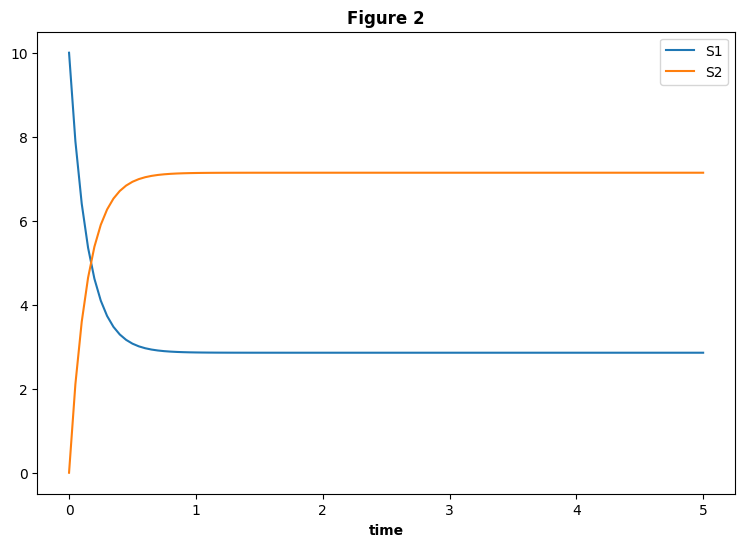

In [4]:
#plot "Figure 1" time vs S1, S2

# create the sedml xml string from the phrasedml
#sbml_str = te.antimonyToSBML(antimony_str)
phrasedml.setReferencedSBML(MODEL_FILE, sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
print(sedml_str)
te.executeSEDML(sedml_str)

# Tasks for SimpleSEDML

1. Run a simulation with changed parameter values
2. Parameter scan
3. Compare the output from two different models
4. Compare simulation results with data

# Repeated tasks in phrasedml

In [5]:
import tellurium as te
import phrasedml

# Define model with Antimony
antimony_str = '''

model anotherModel
   A -> B; 1
   A = 10
   B = 1
end

model enzymeKinetics
    // Compartment
    compartment C = 1.0;
    
    // Species
    species S in C = 10.0;
    species E in C = 1.0;
    species ES in C = 0.0;
    species P in C = 0.0;
    
    // Reactions
    J1: S + E -> ES; k1*S*E;
    J2: ES -> S + E; k2*ES;
    J3: ES -> P + E; k3*ES;
    
    // Parameters
    k1 = 0.1;
    k2 = 0.05;
    k3 = 0.1;
end
'''

# Convert to SBML
sbml_str = te.antimonyToSBML(antimony_str)

# Define PhraSEDML with repeated tasks for parameter sweep
phrasedml_str = '''
    // Reference the model
    model1 = model "enzymeKinetics"
    
    // Define base simulation
    sim1 = simulate uniform(0, 100, 100)
    
    // Define base task
    task0 = run sim1 on model1
    
    // Define repeated task - vary k3 parameter
    task1 = repeat task0 for k3 in [0.05, 0.1, 0.2, 0.5], reset=true
    
    // Plot results
    plot "Product formation with different k3 values" task1.time vs task1.P
    // Add model variable and parameter for reference in the legend
    plot task1.time vs task1.S, task1.E, task1.ES, task1.k3
'''


workingDir = tempfile.mkdtemp(suffix="_sedml")

sbml_file = os.path.join(workingDir, 'enzymeKinetics')
sedml_file = os.path.join(workingDir, 'sed_main.xml')

with open(sbml_file, 'wb') as f:
    f.write(sbml_str.encode('utf-8'))
    f.flush()
    print('SBML written to temporary file')

# Set model reference
phrasedml.setReferencedSBML("enzymeKinetics", sbml_str)

# Convert to SED-ML
sedml_str = phrasedml.convertString(phrasedml_str)

# Execute simulation
if sedml_str:
    te.executeSEDML(sedml_str, workingDir=workingDir)
else:
    print(phrasedml.getLastPhrasedError())

NameError: name 'tempfile' is not defined

In [ ]:
?phrasedml.convertString

In [ ]:
!ls -l /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp1zug2qoa_sedml

In [ ]:
rr = te.loadSBMLModel(sbml_str)
rr.simulate()
rr.plot()

In [ ]:
print(phrasedml_str)

In [ ]:
print(sedml_str)

# Using Phrasedml generated from Claude

In [ ]:
!ls /Users/jlheller/home/Technical/repos/SBMLModel/data/*206*

In [ ]:
# Step 1: Reference the model
phrasedml.setWorkingDirectory("/Users/jlheller/home/Technical/repos/SBMLModel/data")
phrasedml_str = """
model1 = model "BIOMD0000000206.xml"
sim1 = simulate uniform(0, 10, 100)  # 0 to 10 seconds with 100 time points
task1 = run sim1 on model1
plot "BioModel 206 Simulation" time vs s1, s5
"""

In [ ]:
phrasedml_str = phrasedml.convertString(phrasedml_str)
if len(phrasedml.getLastError()) > 0:
    print(phrasedml.getLastError())

# Source is HTTP

In [ ]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"
MODEL = "Wolf2000_Glycolytic_Oscillations"

In [ ]:
rr = te.loadSBMLModel(URL)
wolf_sbml_str = rr.getSBML()

In [ ]:
phrasedml_str = '''
  model1 = model "/tmp/myModel"
  sim1 = simulate uniform(0, 10, 100); sim1.algorithm=CVODE
  task1 = run sim1 on model1
  plot "Figure 2" time vs S1, S2
'''

In [ ]:
print(phrasedml_str)

In [ ]:
# create the sedml xml string from the phrasedml
phrasedml.setReferencedSBML(MODEL, URL)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
print(sedml_str)

# Report

## Simple report

In [ ]:
antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S1 = 10; S2 = 0
  k1 = 1
end
'''

In [ ]:
# FIXME: Must be written as bytes
sbml_str = te.antimonyToSBML(antimony_str)
with open("/tmp/myModel", 'wb') as f:
        f.write(sbml_str.encode('utf-8'))
        f.flush()
        print('SBML written to temporary file')

In [ ]:
# repeated_task = repeat task1 for k1 in [1, 3, 5], reset=true
phrasedml_str = '''
  model1 = model "/tmp/myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  //report task1.time, task1.S1, task1.S2
  report "Concentration over Time" time, S1, S2
'''

In [ ]:
#plot "Figure 1" time vs S1, S2

# create the sedml xml string from the phrasedml
#phrasedml.setReferencedSBML("/tmp/myModel", sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
else:
    print(sedml_str)
    phrasedml.setWorkingDirectory(os.getcwd())
    te.executeSEDML(sedml_str)
    print(te.getLastReport())

In [ ]:
dir(te)

In [ ]:
?te.experiment

## Repeated task

In [ ]:
# repeated_task = repeat task1 for k1 in [1, 3, 5], reset=true
phrasedml_str = '''
  model1 = model "/tmp/myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  repeated_task1 = repeat task1 for k1 in [1, 3, 5], reset=True
  report repeated_task1.time, repeated_task1.S1, repeated_task1.S2
'''

In [ ]:
phrasedml_str = '''
model1 = model "/tmp/myModel"
sim1 = simulate uniform(0, 10, 100)
sim1.algorithm = CVODE
task1 = run sim1 on model1
repeat1 = repeat task1 for k1 in [1, 3, 5], reset=True
report "" repeat1.time, repeat1.S1, repeat1.S2
'''

In [ ]:
#plot "Figure 1" time vs S1, S2

# create the sedml xml string from the phrasedml
#phrasedml.setReferencedSBML("/tmp/myModel", sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
else:
    print(sedml_str)
    te.executeSEDML(sedml_str)
    print(te.getLastReport())

## Repeated Task2

In [14]:
phrasedml_str = '''
model1 = model "/tmp/myModel"
sim1 = simulate uniform(0, 10, 100)
task1 = run sim1 on model1
repeatedTask1 = repeat task1 for k1 in [0.1, 0.5, 1.0], k2 in [0.05, 0.1, 0.2], reset=true
//plot "Substrate Dynamics" repeatedTask1.time vs repeatedTask1.S1
plot repeatedTask1.S1 vs repeatedTask1.S2
'''

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/tmp/myModel"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="10" numberOfSteps="100">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
    <repeatedTask id="repeatedTask1" range="vector_for_k2" resetModel="true">
      <listOfRanges>
        <vectorRange id="vector_for_k1">
          <value> 0.1 </value>
          <value> 0.5 </value>
          <value> 1 </value>
        </vectorRange>
        <vectorRange id="vector_fo

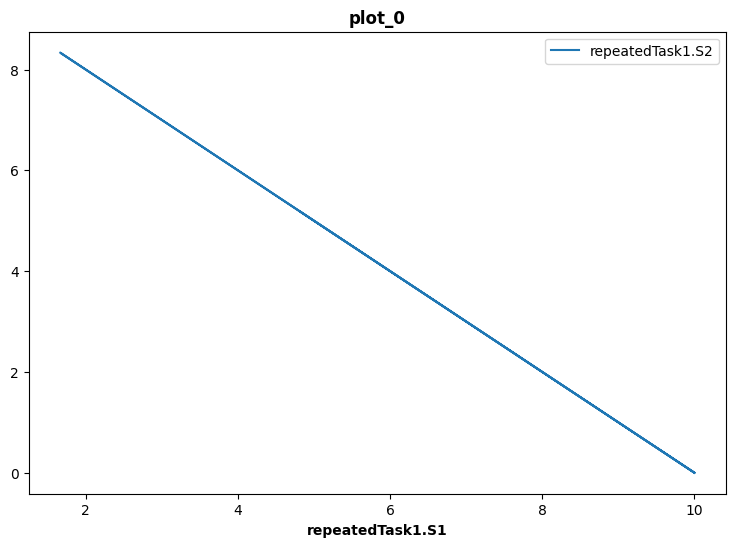

In [15]:
sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
else:
    print(sedml_str)
    te.executeSEDML(sedml_str)

# Parameter Scan

In [67]:
phrasedml_str = '''
  model_3 = model "/tmp/myModel"
  sim_repeat = simulate onestep(3)
  task_1 = run sim_repeat on model_3
  repeatedtask_1 = repeat task_1 for k1 in [0.1, 5, 6, 1], k2 in [0.4, 0.6, 0.7, 0.8]
  plot repeatedtask_1.k1 vs repeatedtask_1.S1, repeatedtask_1.S2
  plot repeatedtask_1.k2 vs repeatedtask_1.S1, repeatedtask_1.S2
  report repeatedtask_1.k1, repeatedtask_1.k2, repeatedtask_1.S1, repeatedtask_1.S2
'''

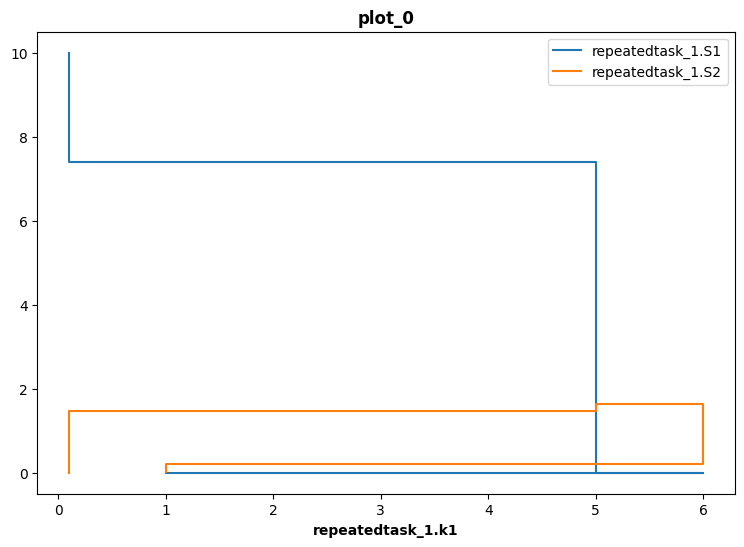

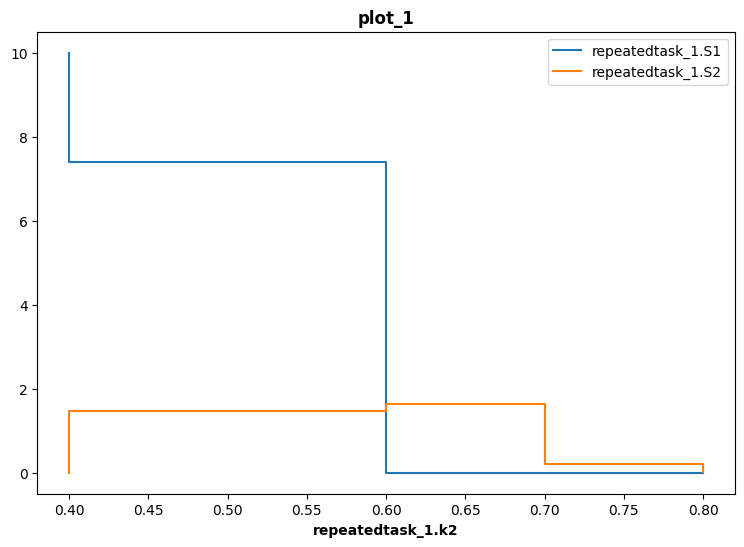

In [68]:
df = execute(phrasedml_str)

In [69]:
df.head(10)

,repeatedtask_1.k1,repeatedtask_1.k2,repeatedtask_1.S1,repeatedtask_1.S2
0,0.1,0.4,1.000000e+01,0.000000
1,0.1,0.4,7.408182e+00,1.465412
2,5.0,0.6,7.408182e+00,1.465412
3,5.0,0.6,2.266304e-06,1.633779
4,6.0,0.7,2.266304e-06,1.633779
5,6.0,0.7,3.452030e-14,0.200067
6,1.0,0.8,3.452030e-14,0.200067
7,1.0,0.8,1.718667e-15,0.018150


# Plots

In [39]:
antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S2 -> S3; k2*S2
  S1 = 10; S2 = 0; S3 = 0;
  k1 = 1
  k2 = 1
end
'''
sbml_str = te.antimonyToSBML(antimony_str)
with open("/tmp/myModel", 'wb') as f:
        f.write(sbml_str.encode('utf-8'))
        f.flush()
        print('SBML written to temporary file')

SBML written to temporary file


In [13]:
phrasedml_str = '''
model1 = model "/tmp/myModel"
sim1 = simulate uniform(0, 10, 100)
task1 = run sim1 on model1
repeatedTask1 = repeat task1 for k1 in [0.1, 0.5, 1.0], k2 in [0.05, 0.1, 0.2], reset=true
//plot "Substrate Dynamics" repeatedTask1.time vs repeatedTask1.S1
plot "My plot" repeatedTask1.time
'''

In [14]:
sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastError())
else:
    #print(sedml_str)
    te.executeSEDML(sedml_str)

Unable to parse line 7 ('plot repeatedTask1_____time'): can only create plots of two or three dimensions, not one.  Use 'report' instead of 'plot' to output one-dimensional data, or use 'vs' to distinguish axes in 2D or 3D data ('plot S1 vs S2').


# Steady State

In [32]:
antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S2 -> S1; k2*S2
  S1 = 10; S2 = 0
  k1 = 1
  k2 = 2
end
'''
MODEL_FILE = "/tmp/my_model.xml"
sbml_str = te.antimonyToSBML(antimony_str)
with open(MODEL_FILE, 'w') as f:
    f.writelines(sbml_str)

In [38]:
phrasedml_str = '''
  model1 = model "%s" with k1 =6
  sim1 = simulate steadystate
  task1 = run sim1 on model1
  report S1, S2
''' % MODEL_FILE
print(phrasedml_str)


  model1 = model "/tmp/my_model.xml" with k1 =6
  sim1 = simulate steadystate
  task1 = run sim1 on model1
  report S1, S2



In [36]:
sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str is None:
    print(phrasedml.getLastError())
else:
    print(sedml_str)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/tmp/my_model.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="6"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <oneStep id="sim1" step="2">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </oneStep>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="report_0_0_0" name="S1">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> S1 </ci>
      </math>
     

In [37]:
te.executeSEDML(sedml_str)
te.getLastReport()

,S1,S2
0,10.000000,0.000000
1,2.500001,7.499999


# Stochastic

In [30]:
phrasedml_str = '''
  model1 = model "%s" with k1 =6
  sim1 = simulate uniform_stochastic(0, 5, 1000)
  task1 = run sim1 on model1
  plot time vs S1, S2
''' % MODEL_FILE
print(phrasedml_str)


  model1 = model "/tmp/my_model.xml" with k1 =6
  sim1 = simulate uniform_stochastic(0, 5, 1000)
  task1 = run sim1 on model1
  plot time vs S1, S2



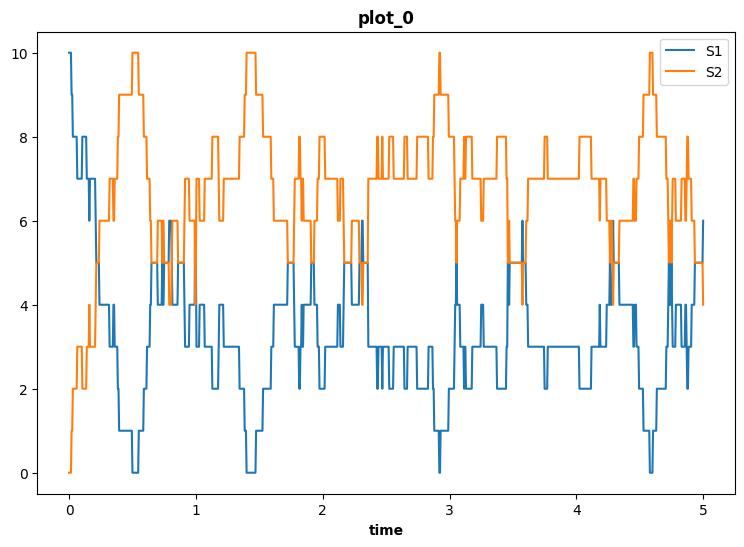

In [31]:
execute(phrasedml_str)

# Notes

1. To execute sedml in Tellurium, need to put the model in an SBML format in a file in a specified working directory.
2. It may be that some part of the sedml workflow fails if the model file has multiple models, that the last model is selected.